<a href="https://colab.research.google.com/github/rodrigohaddad/RNSP/blob/main/t1/t1_kmnist_with_encoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install wisardpkg
#!git clone https://github.com/rois-codh/kmnist.git
#!python kmnist/download_data.py

#!git clone https://gist.github.com/1fe5c78be9a5ec2d507e8118e2c99740.git
#!mv 1fe5c78be9a5ec2d507e8118e2c99740/*.py ./
#!rm -rf ./1fe5c78be9a5ec2d507e8118e2c99740

In [2]:
import wisardpkg as wp

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

from skimage.filters import threshold_otsu, threshold_niblack, threshold_sauvola

from encoder.encoders import ThermometerEncoder, CircularThermometerEncoder, FloatBinaryEncoder

In [3]:
def load(f):
    return np.load(f)['arr_0']

# Load the data
imgs = {'x_train': load('kmnist-train-imgs.npz'),
        'x_test': load('kmnist-test-imgs.npz')}

labels = {'y_train': [str(i) for i in load('kmnist-train-labels.npz')],
          'y_test': [str(i) for i in load('kmnist-test-labels.npz')]}

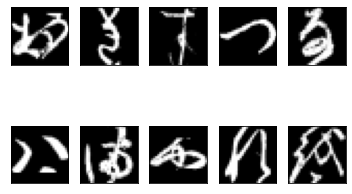

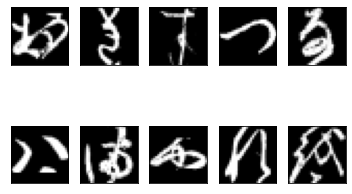

In [4]:
def sample_digit(target, X=imgs['x_train'], y=labels['y_train']):
    return next((digit for (digit, label) in zip(X, y) if label == str(target))).reshape((28,28))

def display_kmnist_digits():
    fig, axs = plt.subplots(2, 5)
    
    for i in range(2):
        for j in range(5):
            axs[i, j].imshow(sample_digit(5*i + j), cmap="gray")
            axs[i, j].axes.xaxis.set_visible(False)
            axs[i, j].axes.yaxis.set_visible(False)
  
    return fig

display_kmnist_digits()

In [106]:
class BinarizeKmnist():
  def basic_bin(self, obj):
    bina = dict()
    for key, value in obj.items():
      bina[key] = [np.where(xis<15, 0, 1).flatten() for xis in value]
    return bina

  def simple_thermometer(self, obj):
    bina = dict()
    therm = ThermometerEncoder(maximum=255, minimum=0, resolution=10)
    for key, value in obj.items():
      bina[key] = [np.uint8(therm.encode(xis)).flatten() for xis in value]
    return bina, therm

  def circular_thermometer(self, obj):
    bina = dict()
    therm = CircularThermometerEncoder(maximum=255, minimum=0, resolution=3)
    for key, value in obj.items():
      bina[key] = [np.uint8(therm.encode(xis)).flatten() for xis in value[0:500]]
    return bina

  def sauvola_niblack(self, obj, window_size, k=0.8, s=True):
    bina = dict()
    for key, value in obj.items():
      bin_imgs = list()
      for img in value:
        thresh_sn = threshold_sauvola(img, window_size=window_size) if s else threshold_niblack(img, window_size=window_size, k=k)
        binary_sn = np.array( img > thresh_sn, dtype=int)
        bin_imgs.append(binary_sn.flatten())
      bina[key] = bin_imgs
    return bina

  def one_hot(self, obj):
    bina = dict()
    onehot_encoder = OneHotEncoder(sparse=False, dtype=int)
    for key, value in imgs.items():
      bina[key] = [onehot_encoder.fit_transform(xis).flatten().tolist() for xis in value[0:10]]
    return bina

In [6]:
def classify(imgs_train, imgs_test, labels_train):
  model_info_kmnist = wp.Wisard(20)
  model_info_kmnist.train(imgs_train, labels_train)
  y_pred = model_info_kmnist.classify(imgs_test)

  return y_pred, model_info_kmnist

In [7]:
def display_digits(images, pixel=28):
  fig, axs = plt.subplots(2, 5, squeeze=True)

  for i, img in enumerate(images.values()):
    img = np.reshape(img, (pixel, pixel))
    img = img/np.max(img)
    fig.axes[i].imshow(img, cmap="gray", vmin=0., vmax=1.)
    fig.axes[i].xaxis.set_visible(False)
    fig.axes[i].yaxis.set_visible(False)

  return fig

In [107]:
binarize = BinarizeKmnist()

0.7886


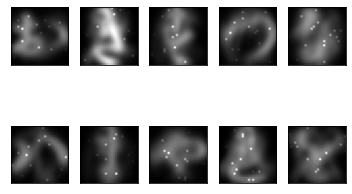

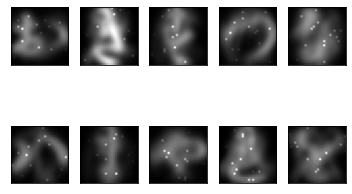

In [9]:
# Simple binarization
imgs_basic_bin = binarize.basic_bin(imgs)
y_pred_sb, model_info_sb_kmnist = classify(imgs_basic_bin['x_train'], imgs_basic_bin['x_test'], labels['y_train'])
print(accuracy_score(labels['y_test'], y_pred_sb))
mi_sb = model_info_sb_kmnist.getMentalImages()
display_digits(mi_sb)

In [10]:
# Simple thermometer
imgs_st_bin, therm_st = binarize.simple_thermometer(imgs)
y_pred_st, model_info_st_kmnist = classify(imgs_st_bin['x_train'], imgs_st_bin['x_test'], labels['y_train'])
print(accuracy_score(labels['y_test'], y_pred_st))
#display_digits(model_info_st_kmnist.getMentalImages(), 140)

0.8083


In [18]:
mi_st = model_info_st_kmnist.getMentalImages()
decoded_mi_st = dict()
mi_st_to_be_resized = mi_st
for key, image in mi_st_to_be_resized.items():
    decoded_mi_st[key] = np.resize(image,784)
display_digits(decoded_mi_st)

In [43]:
# Circular thermometer
imgs_ct_bin = binarize.circular_thermometer(imgs)
y_pred_ct, model_info_ct_kmnist = classify(imgs_ct_bin['x_train'], imgs_ct_bin['x_test'], labels['y_train'][0:500])
print(accuracy_score(labels['y_test'][0:500], y_pred_ct))
#display_digits(model_info_ct_kmnist.getMentalImages())

0.336


0.752


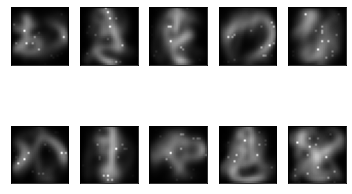

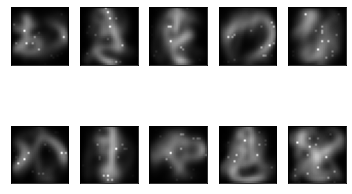

In [10]:
# Sauvola
imgs_sauvola_bin = binarize.sauvola_niblack(imgs, 11)
y_pred_sauvola, model_info_sauvola_kmnist = classify(imgs_sauvola_bin['x_train'], imgs_sauvola_bin['x_test'], labels['y_train'])
print(accuracy_score(labels['y_test'], y_pred_sauvola))
display_digits(model_info_sauvola_kmnist.getMentalImages())

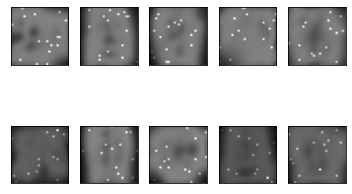

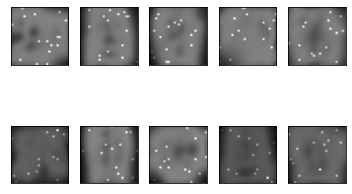

In [9]:
# Niblack
imgs_niblack_bin = binarize.sauvola_niblack(imgs, 11, s=False)
y_pred_niblack, model_info_niblack_kmnist = classify(imgs_niblack_bin['x_train'], imgs_niblack_bin['x_test'], labels['y_train'])
print(accuracy_score(labels['y_test'], y_pred_niblack))
display_digits(model_info_niblack_kmnist.getMentalImages())

In [108]:
# One hot
imgs_one_hot_bin = binarize.one_hot(imgs)
#y_pred_one_hot, model_info_one_hot_kmnist = classify(imgs_one_hot_bin['x_train'], imgs_one_hot_bin['x_test'], labels['y_train'][0:300])
model_info_kmnist = wp.Wisard(5)
model_info_kmnist.train(imgs_one_hot_bin['x_train'], labels['y_train'][0:10])
y_pred = model_info_kmnist.classify(imgs_one_hot_bin['x_test'])
#accuracy_score(labels['y_test'], y_pred_one_hot)
#display_digits(model_info_one_hot_kmnist.getMentalImages())

RuntimeError: The entry size defined on creation of discriminator is different of entry size given as input!

In [110]:
print(type(imgs_one_hot_bin['x_train'][0][0]))

<class 'int'>


In [ ]:
# ClusWisard
clus = wp.ClusWisard(24, 0.1, 10, 10)
clus.train(imgs_sauvola_bin['x_train'], labels['y_train'])
out = clus.classify(imgs_sauvola_bin['x_test'])
accuracy_score(labels['y_test'], out)